In [ ]:
import kagglehub
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score



In [ ]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Path to dataset files:", path)

# 1. Set your local dataset path
data_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

# 2. Define image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
# 3. Load full dataset
dataset_tmp = datasets.ImageFolder(root=data_dir, transform=transform)

Path to dataset files: /kaggle/input/140k-real-and-fake-faces


In [ ]:
print(dataset_tmp.class_to_idx)


{'fake': 0, 'real': 1}


In [ ]:
import random
from torch.utils.data import Subset

# Target: 500 images per class (class 0 = real, class 1 = fake)
samples_per_class = 500
class_indices = {0: [], 1: []}

# Collect indices per class
for idx, (paths, label) in enumerate(dataset_tmp.samples):
    if len(class_indices[label]) < samples_per_class:
        class_indices[label].append(idx)
    if all(len(lst) == samples_per_class for lst in class_indices.values()):
        break

# Combine and shuffle
print(len(class_indices[0]),len(class_indices[1]))
final_indices = class_indices[0] + class_indices[1]
random.shuffle(final_indices)

# Make the balanced subset
dataset = Subset(dataset_tmp, final_indices)


500 500


In [ ]:
#print(small_dataset)
# dataset= small_dataset

In [ ]:
# 4. Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [ ]:
# 5. Load pretrained ResNet and modify final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s]


In [ ]:
# 6. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")
        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
        acc = accuracy_score(all_labels, all_preds)
        print(f"Validation Accuracy: {acc*100:.2f}%\n")
# 8. Train the model
train_model(model, train_loader, val_loader, epochs=5)

Epoch [1/5], Loss: 0.6270
Validation Accuracy: 81.00%

Epoch [2/5], Loss: 0.1129
Validation Accuracy: 85.50%

Epoch [3/5], Loss: 0.0252
Validation Accuracy: 85.00%

Epoch [4/5], Loss: 0.0076
Validation Accuracy: 86.50%

Epoch [5/5], Loss: 0.0048
Validation Accuracy: 88.00%



In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
def predict_image(image_path, model, transform, class_names):
    model.eval()

    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    # Preprocess
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
    predicted_label = class_names[pred_idx.item()]
    confidence_pct = confidence.item() * 100
    # Plot the image with prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label} ({confidence_pct:.2f}%)")
    plt.show()
    return predicted_label

In [ ]:
def predict_image_without_display(image_path, model, transform, class_names):
    model.eval()

    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    # Preprocess
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
    predicted_label = class_names[pred_idx.item()]
    confidence_pct = confidence.item() * 100

    return predicted_label

['fake', 'real']
/kaggle/input/140k-real-and-fake-faces
🔍 Real Image Prediction:


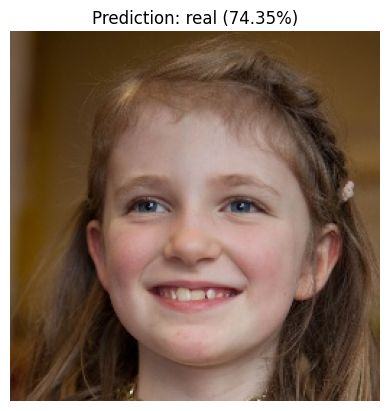

real
🔍 Fake Image Prediction:


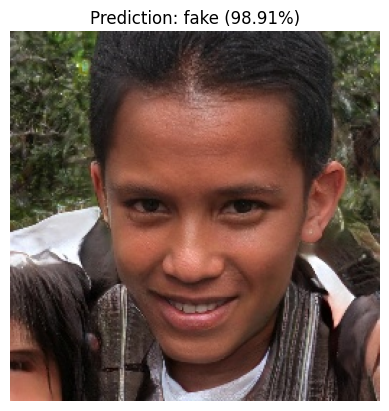

fake


In [ ]:
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
# Get class labels
class_names = dataset.dataset.classes if isinstance(dataset, torch.utils.data.Subset) else dataset.classes
print(class_names)
#assert(0)
#kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake
print(path)
real_img_path = os.path.join(path, "real_vs_fake","real-vs-fake","test", "real", "09678.jpg")
fake_img_path = os.path.join(path, "real_vs_fake","real-vs-fake","test", "fake", "L80G53GM1T.jpg")
# Run prediction
print("🔍 Real Image Prediction:")
print(predict_image(real_img_path, model, predict_transform, class_names))
print("🔍 Fake Image Prediction:")
print(predict_image(fake_img_path, model, predict_transform, class_names))

In [ ]:
import os

predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
# Get class labels
class_names = dataset.dataset.classes if isinstance(dataset, torch.utils.data.Subset) else dataset.classes

# Set test folders
real_dir = os.path.join(path, "real_vs_fake", "real-vs-fake", "test", "real")
fake_dir = os.path.join(path, "real_vs_fake", "real-vs-fake", "test", "fake")



In [ ]:
# Counters
breaker =10000

In [ ]:
real_correct = 0
real_wrong_as_fake = 0

i =0
# Predict on real images
for filename in os.listdir(real_dir):
    if i >= breaker:
      break
    if filename.endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(real_dir, filename)
        pred = predict_image_without_display(img_path, model, predict_transform, class_names)
        if pred == "real":
            real_correct += 1
        else:
            real_wrong_as_fake += 1
        i+=1


# Final report
print("🟩 REAL images:")
print(f"✅ Correctly predicted real: {real_correct}")
print(f"❌ Wrongly predicted as fake: {real_wrong_as_fake}")



🟩 REAL images:
✅ Correctly predicted real: 8468
❌ Wrongly predicted as fake: 1532


In [ ]:


fake_correct = 0
fake_wrong_as_real = 0
# Predict on fake images
i=0
for filename in os.listdir(fake_dir):
    if i >= breaker:
      break
    if filename.endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(fake_dir, filename)
        pred = predict_image_without_display(img_path, model, predict_transform, class_names)
        if pred == "fake":
            fake_correct += 1
        else:
            fake_wrong_as_real += 1
        i+=1


print("\n🟥 FAKE images:")
print(f"✅ Correctly predicted fake: {fake_correct}")
print(f"❌ Wrongly predicted as real: {fake_wrong_as_real}")



🟥 FAKE images:
✅ Correctly predicted fake: 8796
❌ Wrongly predicted as real: 1204


In [ ]:
# === Calculate overall test accuracy ===
total_correct = real_correct + fake_correct
total_images = real_correct + real_wrong_as_fake + fake_correct + fake_wrong_as_real
test_accuracy = total_correct / total_images * 100

print("\n📊 Test Set Accuracy: {:.2f}%".format(test_accuracy))



📊 Test Set Accuracy: 86.32%
